<a href="https://colab.research.google.com/github/argon1um/TextClassificationPython/blob/main/TextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Dataset - https://www.tensorflow.org/datasets/catalog/imdb_reviews

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1,   1,   7, ...,   0,   0,   0],
       [ 48,   7,  22, ...,   0,   0,   0],
       [ 10, 479,  11, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 51s 104ms/step - loss: 0.6359 - accuracy: 0.5801 - val_loss: 0.4844 - val_accuracy: 0.7505
Epoch 2/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3989 - accuracy: 0.8152 - val_loss: 0.3628 - val_accuracy: 0.8427
Epoch 3/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3421 - accuracy: 0.8491 - val_loss: 0.3491 - val_accuracy: 0.8469
Epoch 4/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3229 - accuracy: 0.8607 - val_loss: 0.3339 - val_accuracy: 0.8516
Epoch 5/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3144 - accuracy: 0.8638 - val_loss: 0.3263 - val_accuracy: 0.8557
Epoch 6/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3096 - accuracy: 0.8662 - val_loss: 0.3291 - val_accuracy: 0.8557
Epoch 7/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3087 - accuracy: 0.8674 - val_loss: 0.3291 - val_accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 31ms/step - loss: 0.3165 - accuracy: 0.8587
Test Loss: 0.3165145814418793
Test Accuracy: 0.858680009841919


(0.0, 0.6526370421051979)

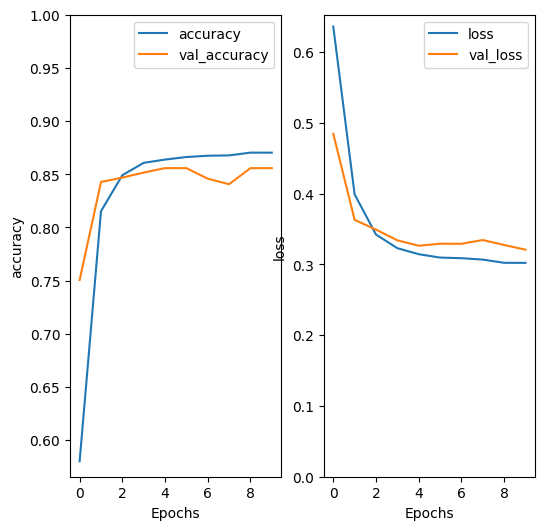

In [ ]:
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Данные для ожидаемой единицы

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[0.5296338]


In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 77s 153ms/step - loss: 0.6072 - accuracy: 0.6058 - val_loss: 0.4157 - val_accuracy: 0.7969
Epoch 2/10
391/391 [==============================] - 48s 121ms/step - loss: 0.3799 - accuracy: 0.8366 - val_loss: 0.3433 - val_accuracy: 0.8562
Epoch 3/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3317 - accuracy: 0.8600 - val_loss: 0.3257 - val_accuracy: 0.8599
Epoch 4/10
391/391 [==============================] - 48s 121ms/step - loss: 0.3148 - accuracy: 0.8666 - val_loss: 0.3196 - val_accuracy: 0.8630
Epoch 5/10
391/391 [==============================] - 45s 115ms/step - loss: 0.3088 - accuracy: 0.8684 - val_loss: 0.3254 - val_accuracy: 0.8557
Epoch 6/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3074 - accuracy: 0.8698 - val_loss: 0.3195 - val_accuracy: 0.8526
Epoch 7/10
391/391 [==============================] - 45s 116ms/step - loss: 0.3011 - accuracy: 0.8744 - val_loss: 0.3232 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 20s 52ms/step - loss: 0.3312 - accuracy: 0.8632
Test Loss: 0.3312261998653412
Test Accuracy: 0.8632000088691711


Данные для ожидаемого нуля

In [ ]:

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-1.8220959]]


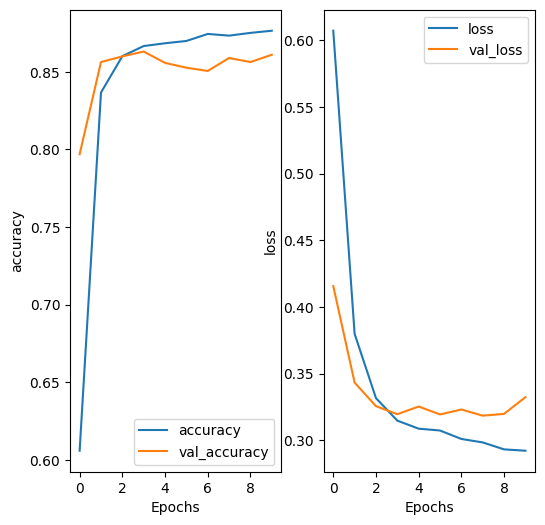

In [ ]:
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')